## 1 Import Libraries and Data

In [25]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

# import Dataframes with cleaned data independently of the operating system (mac or windows or linux) in a pandas dataframe
charging_data = pd.read_pickle(os.path.join('Data', 'charging_data.pkl'))
weather_data = pd.read_pickle(os.path.join('Data', 'weather_data.pkl'))

In [26]:
# charging_data.head()
print(charging_data.columns)
weather_data.head()


Index(['counter', 'id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID',
       'timezone', 'userID', 'userInputs', 'connection_date',
       'charging_duration', 'connection_duration'],
      dtype='object')


,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature,weather_date
0,Burbank,2018-01-01 08:53:00-08:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0,2018-01-01
1,Burbank,2018-01-01 09:53:00-08:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0,2018-01-01
2,Burbank,2018-01-01 10:53:00-08:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0,2018-01-01
3,Burbank,2018-01-01 11:53:00-08:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0,2018-01-01
4,Burbank,2018-01-01 12:53:00-08:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0,2018-01-01


## 2 Descriptive Analysis

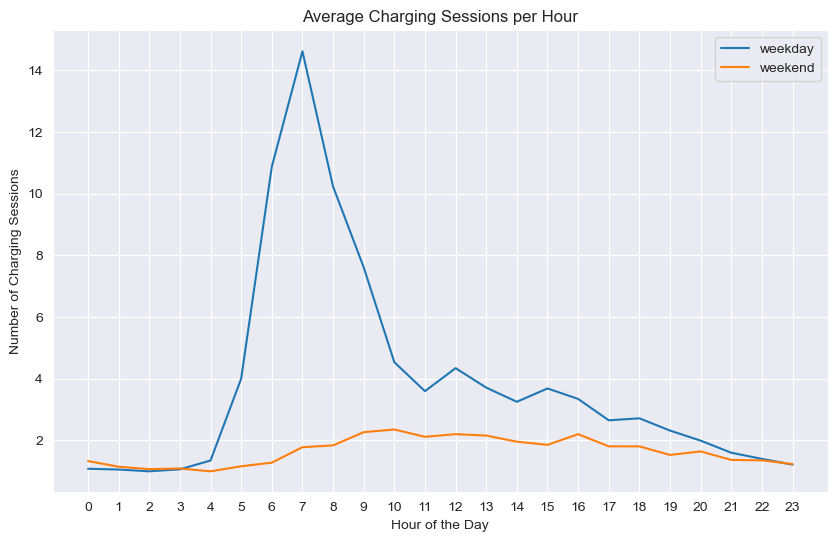

In [27]:
charging_data["day"] = charging_data["connectionTime"].dt.day_name()
charging_data['isWeekend'] = charging_data['day'].isin(['Saturday', 'Sunday'])
charging_data["hour"] = charging_data["connectionTime"].dt.hour
charging_data["date"] = charging_data["connectionTime"].dt.date

# calculate number of charging sessions per day and hour
sessions_per_hour_day_weekend = charging_data[charging_data['isWeekend']].groupby(["date", "hour"]).size().reset_index(
    name="count")
sessions_per_day_weekday = charging_data[~charging_data['isWeekend']].groupby(["date", "hour"]).size().reset_index(
    name="count")
# print(sessions_per_hour_day_weekend.head())

# calculate average number of charging sessions per hour
average_sessions_per_hour_weekend = sessions_per_hour_day_weekend.groupby("hour")["count"].mean()
average_sessions_per_weekday = sessions_per_day_weekday.groupby("hour")["count"].mean()

plt.figure(figsize=(10, 6))
average_sessions_per_weekday.plot(kind="line", label="weekday")
average_sessions_per_hour_weekend.plot(kind="line", label="weekend")
plt.title("Average Charging Sessions per Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Charging Sessions")
plt.xticks(range(0, 24))
plt.legend(loc=0)
plt.grid(True)
plt.show()

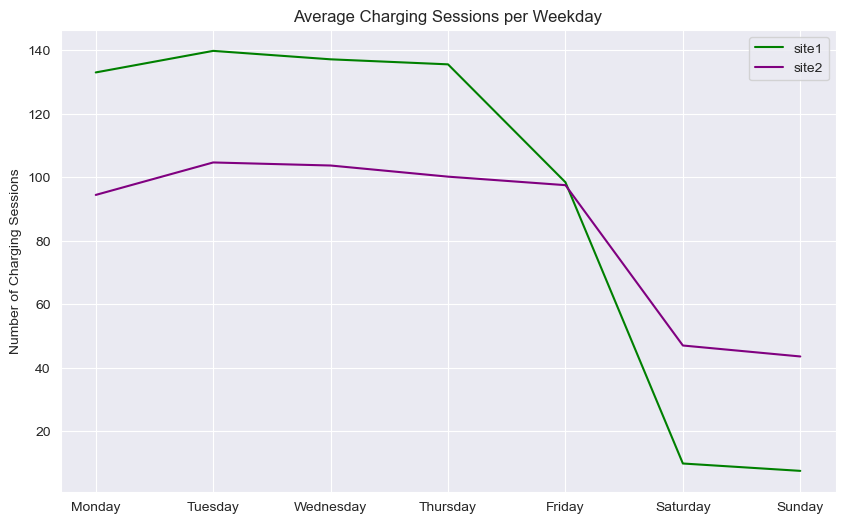

In [28]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
charging_data['day'] = pd.Categorical(charging_data['day'], categories=weekday_order, ordered=True)
charging_data['week'] = charging_data["connectionTime"].dt.isocalendar().week

# calculate number of charging sessions per week and day
sessions_per_week_weekday_site1 = charging_data[charging_data['siteID'] == '1'].groupby(['week', 'day'],
                                                                                        observed=False).size()
sessions_per_week_weekday_site2 = charging_data[charging_data['siteID'] == '2'].groupby(['week', 'day'],
                                                                                        observed=False).size()
# print(sessions_per_day_weekday_site1.head())

# calculate average number of charging sessions per weekday
average_sessions_per_weekday_site1 = sessions_per_week_weekday_site1.groupby('day', observed=False).mean()
average_sessions_per_weekday_site2 = sessions_per_week_weekday_site2.groupby('day', observed=False).mean()

plt.figure(figsize=(10, 6))
average_sessions_per_weekday_site1.plot(kind='line', label='site1', color='green')
average_sessions_per_weekday_site2.plot(kind='line', label='site2', color='purple')
plt.title('Average Charging Sessions per Weekday')
plt.xlabel(None)
plt.ylabel('Number of Charging Sessions')
plt.legend(loc=0)
plt.grid(True)
plt.show()

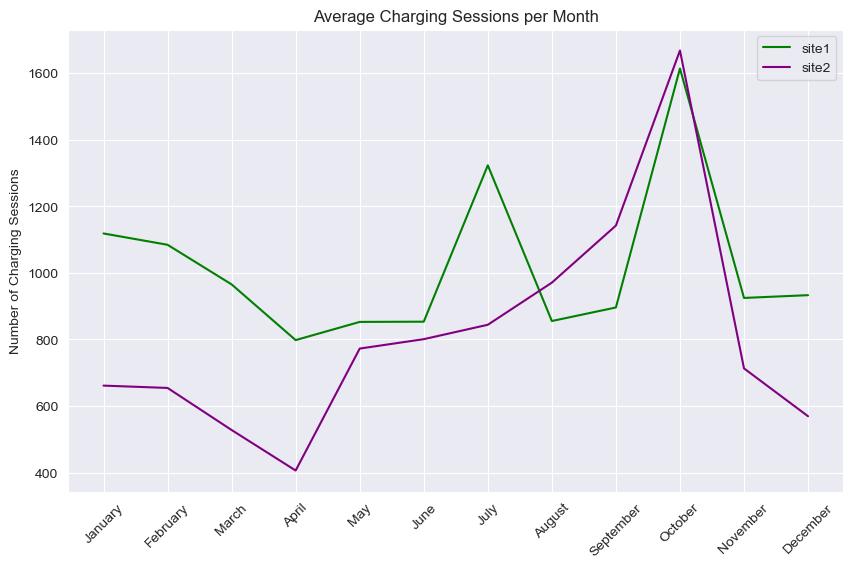

In [29]:
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October',
                'November', 'December']
charging_data['month'] = pd.Categorical(charging_data['connectionTime'].dt.month_name(), categories=months_order,
                                        ordered=True)
charging_data['year'] = charging_data['connectionTime'].dt.year

# calculate number of charging sessions per day and day of the week
sessions_per_year_month_site1 = charging_data[charging_data['siteID'] == '1'].groupby(['year', 'month'],
                                                                                      observed=True).size()
sessions_per_year_month_site2 = charging_data[charging_data['siteID'] == '2'].groupby(['year', 'month'],
                                                                                      observed=True).size()
# print(sessions_per_year_month_site1)

# calculate average number of charging sessions per day of the week
average_sessions_per_month_site1 = sessions_per_year_month_site1.groupby('month', observed=False).mean()
average_sessions_per_month_site2 = sessions_per_year_month_site2.groupby('month', observed=False).mean()

plt.figure(figsize=(10, 6))
average_sessions_per_month_site1.plot(kind='line', label='site1', color='green')
average_sessions_per_month_site2.plot(kind='line', label='site2', color='purple')
plt.title('Average Charging Sessions per Month')
plt.xlabel(None)
plt.ylabel('Number of Charging Sessions')
plt.legend(loc=0)
plt.xticks(range(0, 12), months_order, rotation=45)
plt.grid(True)
plt.show()

## 3 Utilization Prediction
### Data Preparation

In [30]:
def aggregate_charging_data(df):

    # Erstellen einer Liste aller Stunden im Datumsbereich
    start_date = df['connectionTime'].min().floor('h')  # Auf die volle Stunde abrunden
    end_date = df['disconnectTime'].max().ceil('h') # Auf die nächste volle Stunde aufrunden
    all_hours = pd.date_range(start=start_date, end=end_date, freq='h')

    # Erstellen eines leeren DataFrames für die aggregierten Daten
    aggregated_df = pd.DataFrame(index=all_hours)
    aggregated_df.index.name = 'start_hour' # Index benennen für bessere Lesbarkeit
    # Hinzufügen der Zeitspalten
    aggregated_df['hour_of_day'] = aggregated_df.index.hour
    aggregated_df['week_of_year'] = aggregated_df.index.isocalendar().week
    aggregated_df['day_of_week'] = aggregated_df.index.dayofweek # 0=Montag, 6=Sonntag
    aggregated_df['month_of_year'] = aggregated_df.index.month
    aggregated_df['is_weekend'] = aggregated_df.index.dayofweek >= 5 # Samstag (5) oder Sonntag (6)

    # Iterieren über die Standorte
    for site_id in df['siteID'].unique():
        site_df = df[df['siteID'] == site_id].copy()

        hourly_usage = []
        hourly_kwh_delivered = []
        for hour in all_hours:
            start_of_hour = hour
            end_of_hour = hour + pd.Timedelta(hours=1)

            # Alle chargingSessions, die in der Stunde aktiv waren
            #   folgende Edge-Cases werden aber mitgezählt!:
            #       Wenn eine session genau zum Anfang der Stunde beendet wurde oder
            #       Wenn eine session genau zum Ende der Stunde anfängt
            active_chargers = site_df[(site_df['connectionTime'] <= end_of_hour) & (site_df['disconnectTime'] >= start_of_hour)]
            hourly_usage.append(len(active_chargers))

            # Berechnung der kWhDelivered pro Stunde
            total_kwh_in_hour = 0
            for _, charger in active_chargers.iterrows():
                # Wir wollen die kwhDelivered anteilig berechnen:
                #   daher nehmen wir entweder die connectionTime oder start_hour - je nachdem was größer ist
                #   bei der disconnectTime genauso nur umgekehrt
                connection_time = max(charger['connectionTime'], start_of_hour)
                disconnect_time = min(charger['disconnectTime'], end_of_hour)
                # Zeit die tatsächlich in der Stunde geladen wurde
                duration_in_hour = (disconnect_time - connection_time).total_seconds() / 3600 #Dauer in Stunden
                
                # Edge Cases: chargingSessions haben genau zum Ende der Stunde angefangen 
                #               bzw. zum Anfang der Stunde aufgehört
                if duration_in_hour > 0:
                    kwh_in_hour = (charger['kWhDelivered'] / 
                                   ((charger['disconnectTime'] - charger['connectionTime']).total_seconds() / 3600)) * duration_in_hour
                    total_kwh_in_hour += kwh_in_hour

            hourly_kwh_delivered.append(total_kwh_in_hour)

        aggregated_df[f'site_{site_id}_usage'] = hourly_usage
        aggregated_df[f'site_{site_id}_kwhDelivered'] = hourly_kwh_delivered

    aggregated_df.fillna(0, inplace=True)
    return aggregated_df

aggregated_data = aggregate_charging_data(charging_data)
aggregated_data.head()

,hour_of_day,week_of_year,day_of_week,month_of_year,is_weekend,site_1_usage,site_1_kwhDelivered,site_2_usage,site_2_kwhDelivered
start_hour,,,,,,,,,
2018-04-25 04:00:00-07:00,4,17,2,4,False,0,0.0,1,3.118359
2018-04-25 05:00:00-07:00,5,17,2,4,False,0,0.0,1,3.602725
2018-04-25 06:00:00-07:00,6,17,2,4,False,0,0.0,3,1.565481
2018-04-25 07:00:00-07:00,7,17,2,4,False,0,0.0,7,3.163750
2018-04-25 08:00:00-07:00,8,17,2,4,False,0,0.0,22,14.703062


In [31]:
# TODO Wir müssen uns nochmal ums genaue mergen kümmern:
#   bei den sessions sind die timestamps mit -7:00 am Ende, bei den Wetterdaten mit -8:00
#   und die Wetterdaten werden immer um 7:53h, 8:53h etc. geliefert -> man müsste also eigentlich auf die nächste Stunde aufrunden
#   ... das klappt aber nicht wegen den verschissenen Sommer-Zeitumstellungen (hab noch keine Lösung gefunden)
# weather_data['timestamp'] = weather_data['timestamp'].dt.round('h')

# auf stündliche Daten reduzieren (falls irgendwo mehrere Aufzeichnungen pro Stunde geliefert werden)
weather_df = weather_data.set_index('timestamp').resample('h').first().reset_index()
weather_df = weather_df.rename(columns={'timestamp': 'start_hour'})

merged_df = pd.merge(aggregated_data, weather_df, on='start_hour', how='left')
merged_df.drop(columns=['city', 'felt_temperature', 'weather_date'], inplace=True)
merged_df.head()


,start_hour,hour_of_day,week_of_year,day_of_week,month_of_year,is_weekend,site_1_usage,site_1_kwhDelivered,site_2_usage,site_2_kwhDelivered,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation
0,2018-04-25 04:00:00-07:00,4,17,2,4,False,0,0.0,1,3.118359,18.0,29.0,Partly Cloudy,987.80,15.0,0.0
1,2018-04-25 05:00:00-07:00,5,17,2,4,False,0,0.0,1,3.602725,17.0,33.0,Fair,988.45,9.0,0.0
2,2018-04-25 06:00:00-07:00,6,17,2,4,False,0,0.0,3,1.565481,16.0,33.0,Fair,988.78,13.0,0.0
3,2018-04-25 07:00:00-07:00,7,17,2,4,False,0,0.0,7,3.163750,15.0,33.0,Fair,988.78,13.0,0.0
4,2018-04-25 08:00:00-07:00,8,17,2,4,False,0,0.0,22,14.703062,14.0,29.0,Partly Cloudy,988.78,7.0,0.0
